# **Problem 9**

# Library Imports


In [1]:
# library imports
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [41]:
# constants
TRUE_THETA = 2
SAMPLE_SIZE = 500
PRIOR = (3, 1)
CONF_INTERVALS = {"90%": 1.645, "95%": 1.960, "99%": 2.576}

# Part (a)
## PDF of Prior

In [42]:
# utility function for gamma distribution
def get_gamma_mean(alpha, beta):
  return alpha / beta

def get_gamma_std(alpha, beta):
  return (alpha ** 0.5) / beta

In [43]:
# function for plotting a gamma distribution
def plot_gamma(label, alpha, beta):
  x = np.linspace(
      stats.gamma.ppf(0.01, alpha, scale = 1 / beta),
      stats.gamma.ppf(0.99, alpha, scale = 1 / beta),
      num = 500
  )
  y = stats.gamma.pdf(x, alpha, scale = 1 / beta)
  plt.plot(
      x, y,
      lw = 2, c = "r", label = "gamma pdf"
  )
  plt.title(
      "{} Gamma Distribution \u03B1 = {}, \u03B2 = {}".format(
        label, alpha, beta
      ),
      fontsize = 15
  )
  plt.vlines(
      x = get_gamma_mean(alpha, beta),
      ymin = np.min(y), ymax = np.max(y),
      color = "b", lw = 2,
      label = "distr mean = {}".format(round(get_gamma_mean(alpha, beta), 2))
  )
  plt.legend()
  plt.show()

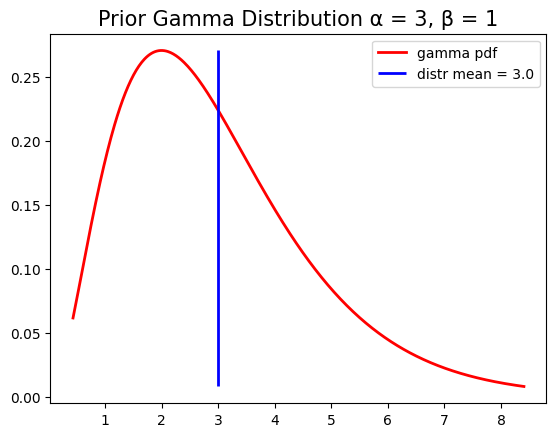

In [44]:
# plot the prior distribution
plot_gamma("Prior", PRIOR[0], PRIOR[1])

# Part (b)

## Prob Distribution of Model (Poisson)

In [45]:
# function for plotting a poisson distribution
def plot_poisson(label, theta):
  x = np.arange(0, 5 * theta + 1, 0.5)
  y = stats.poisson.pmf(x, theta)
  plt.bar(
      x, y,
      align = "center",
      label = "poisson pmf"
  )
  plt.title(
      "{}\nPoisson Distribution with \u03B8 = {}".format(label, round(theta, 2)),
      fontsize = 15
  )
  plt.vlines(
      x = theta,
      ymin = 0, ymax = np.max(y),
      color = "b", lw = 2,
      label = "distr mean (theta) = {}".format(round(theta, 2))
  )
  plt.legend()
  plt.show()

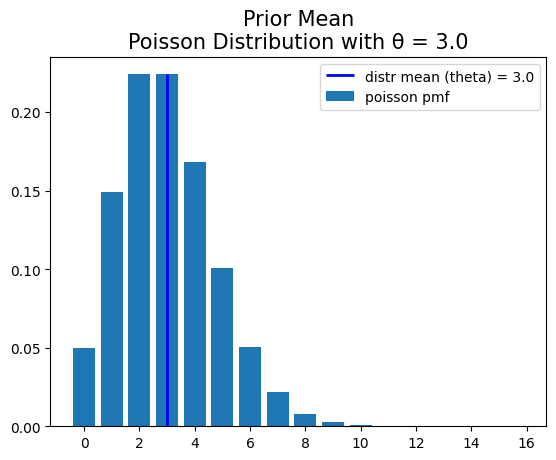

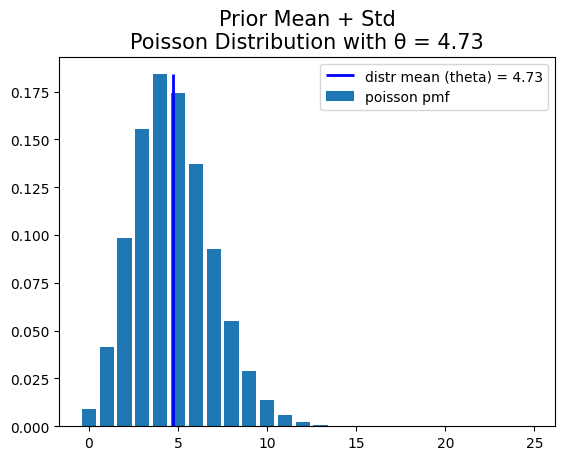

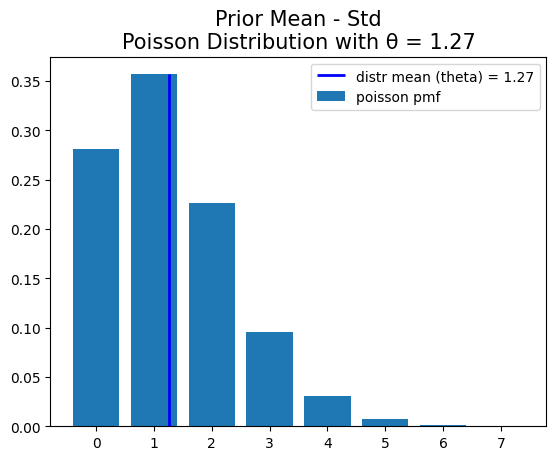

In [46]:
# theta = prior mean
plot_poisson("Prior Mean", get_gamma_mean(PRIOR[0], PRIOR[1]))
plot_poisson(
    "Prior Mean + Std",
    get_gamma_mean(PRIOR[0], PRIOR[1]) + get_gamma_std(PRIOR[0], PRIOR[1])
)
plot_poisson(
    "Prior Mean - Std",
    get_gamma_mean(PRIOR[0], PRIOR[1]) - get_gamma_std(PRIOR[0], PRIOR[1])
)

# Part (c) & (d)
## Incrementally updating and plotting the gamma params

In [47]:
# function to draw data points from Poisson distr with true theta
def get_sample_points(size = SAMPLE_SIZE, theta = TRUE_THETA):
  return stats.poisson.rvs(theta, size = size)

In [63]:
# drawing the sample points
data = get_sample_points()
data.shape

(500,)

Result from DGS/Lecture:

For Prior - $\xi(\theta) \propto \Gamma(\alpha, \beta)$ and Model - $f(x_i | \theta) \propto Poisson(\theta)$,

Posterior is $f(\theta | x_i) \propto \Gamma(\alpha + x_i, \beta + 1)$

In [49]:
# updating the prior to get posterior with one datapoint
def get_posterior(alpha, beta, x):
  return (alpha + x, beta + 1)

# incrementally updating the priors
def bayesian_update(data, prior = PRIOR):
  alpha, beta = prior
  posterior_alpha, posterior_beta = [], []
  for x in data:
    alpha, beta = get_posterior(alpha, beta, x)
    posterior_alpha.append(alpha)
    posterior_beta.append(beta)
  return (np.array(posterior_alpha), np.array(posterior_beta))

In [64]:
# calculate the posterior alphas and betas
posterior_alpha, posterior_beta = bayesian_update(data)
print(posterior_alpha.shape, posterior_beta.shape)

(500,) (500,)


In [65]:
# calculate the posterior means and std devs
posterior_mean = get_gamma_mean(posterior_alpha, posterior_beta)
posterior_std = get_gamma_std(posterior_alpha, posterior_beta)
print(posterior_mean.shape, posterior_std.shape)

(500,) (500,)


In [52]:
# plotting utility for posterior params/statistics
def plot_posterior_property(prop, values, color = "r"):
  plt.plot(
      [i + 1 for i in range(values.shape[0])],
      values,
      lw = 2, c = color
  )
  plt.xlabel("i", fontsize = 10)
  plt.ylabel("{}".format(prop))
  plt.title(
      "{} versus Number of Updations".format(prop),
      fontsize = 15
  )
  plt.show()

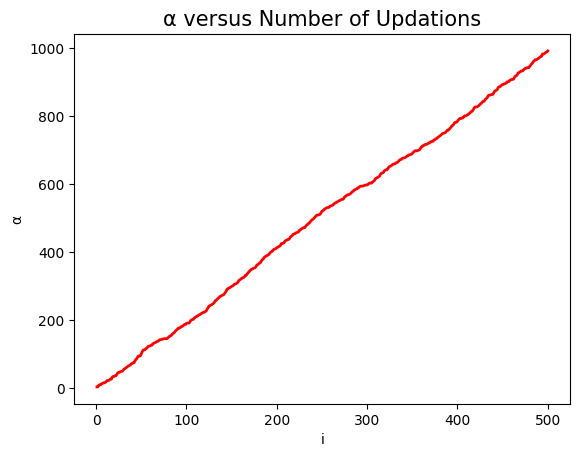

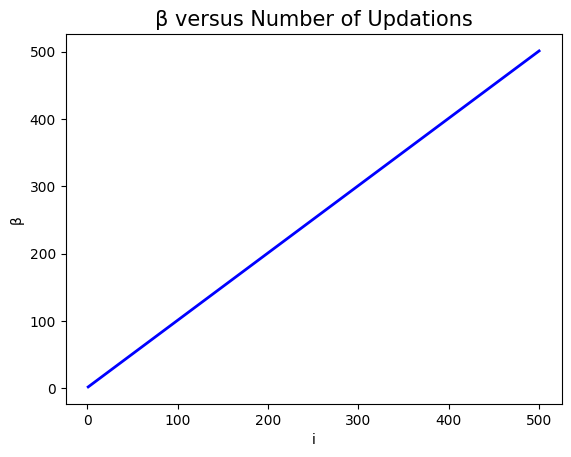

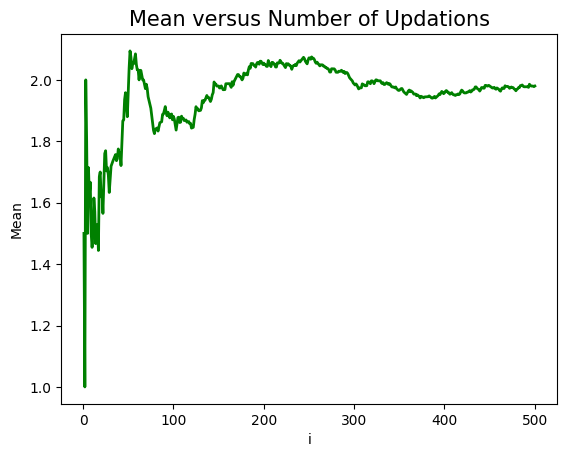

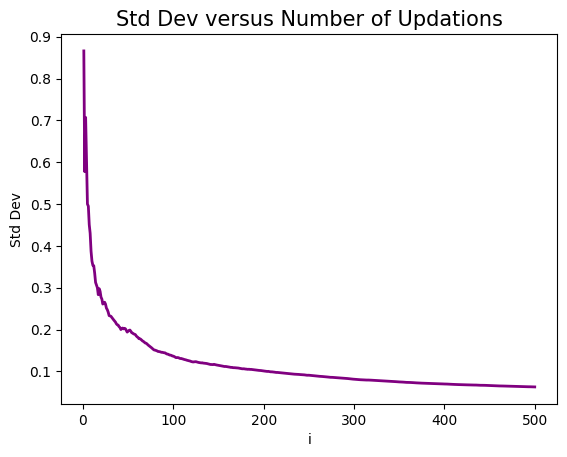

In [66]:
plot_posterior_property("\u03B1", posterior_alpha, color = "red")
plot_posterior_property("\u03B2", posterior_beta, color = "blue")
plot_posterior_property("Mean", posterior_mean, color = "green")
plot_posterior_property("Std Dev", posterior_std, color = "purple")

# Part (e)

## Plotting Selected Posteriors

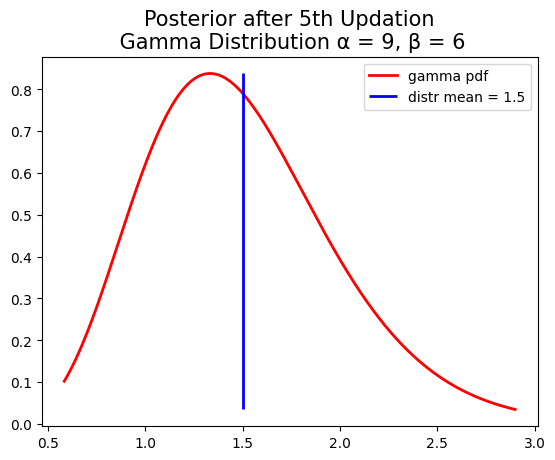

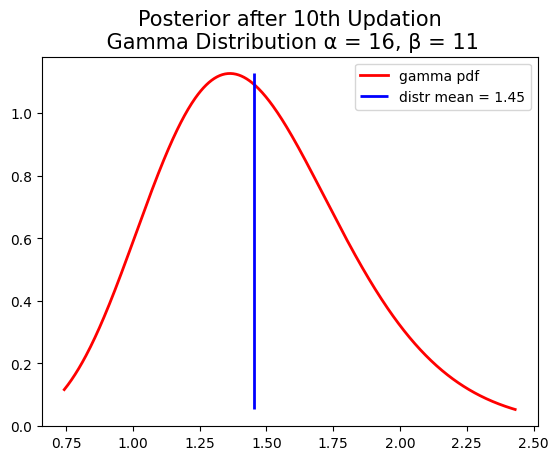

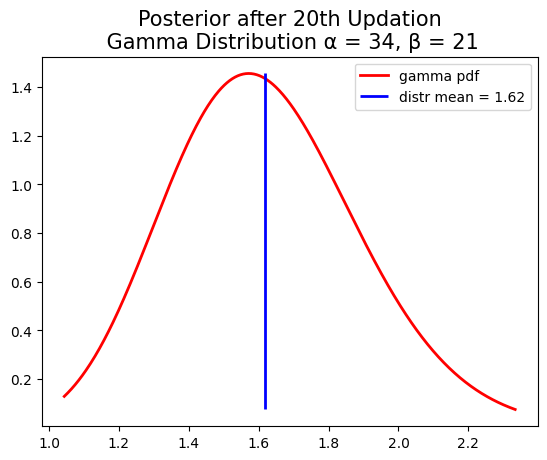

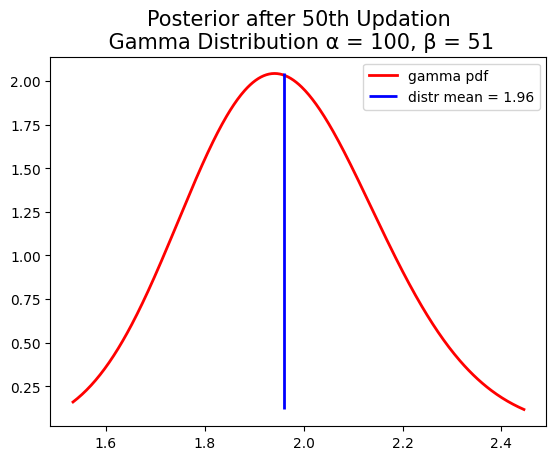

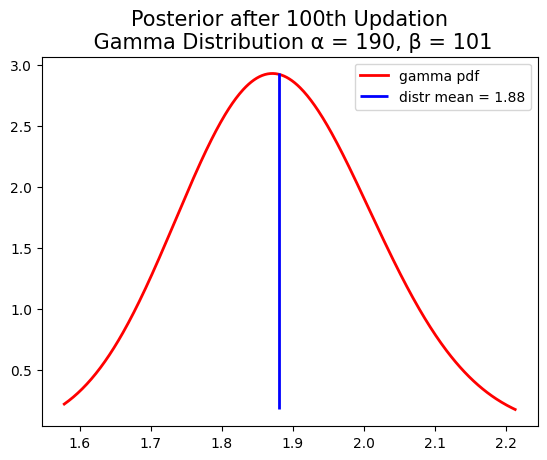

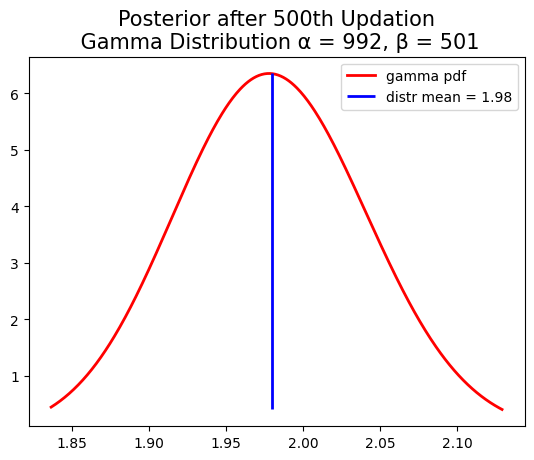

In [67]:
selected_posteriors = [5, 10, 20, 50, 100, 500]
for i in selected_posteriors:
  plot_gamma(
      "Posterior after {}th Updation\n".format(i),
      posterior_alpha[i - 1],
      posterior_beta[i - 1]
  )

# Part (f)

## Plotting Bayesian Estimators with C.I.s

Result from DGS/Lecture:

For quadratic loss, the Bayesian estimator is the posterior mean.

In [55]:
# function to plot estimators after each updation/iteration
# along with their specified conf intervals
def plot_estimators(
    estimator, value, std_dev,
    conf_intervals = CONF_INTERVALS
):
  plt.figure(figsize = (10, 10))
  plt.title(
      "{} After Each Updation".format(estimator)
  )
  plt.ylabel("Estimator Value", fontsize = 10)
  plt.xlabel("i", fontsize = 10)

  x = [i + 1 for i in range(value.shape[0])]
  colors = ["red", "blue", "green", "black", "purple"]
  plt.plot(
      x, value,
      color = colors[0], lw = 2,
      label = "Estimator Value"
  )
  idx = 1
  for interval in conf_intervals.keys():
    plt.plot(
        x, value + conf_intervals[interval] * std_dev,
        color = colors[idx], lw = 1,
        label = "{} Confidence Interval".format(interval)
    )
    plt.plot(
        x, value - conf_intervals[interval] * std_dev,
        color = colors[idx], lw = 1,
    )
    idx += 1
  plt.axhline(
      y = TRUE_THETA,
      color = colors[idx], linestyle = "-", lw = 1,
      label= "True Theta"
  )
  plt.legend()
  plt.show()

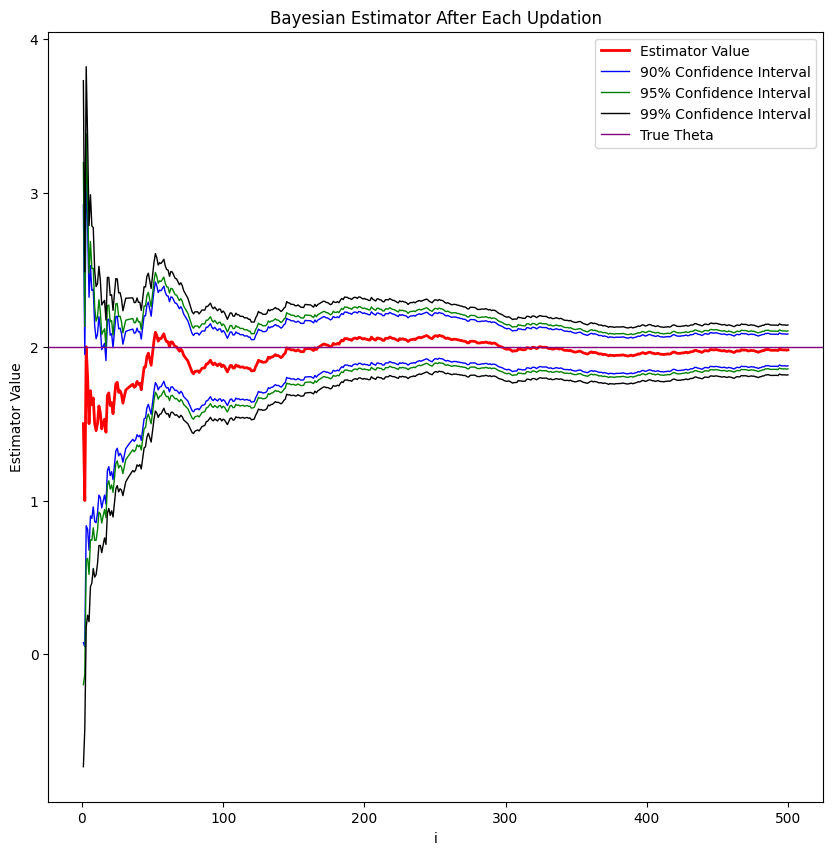

In [68]:
# plotting the bayesian estimators along with confidence intervals
bayesian_estimator = posterior_mean
plot_estimators("Bayesian Estimator", bayesian_estimator, posterior_std)

# Part (g)

## Derivations for MLE

### Maximum Likelihood Estimator

For each $X_i$, $f(X_i | \theta) = e^{-\theta} \theta^{X_i} / X_i!$.

Therefore, the likelihood function $\Pi_i f(X_i | \theta)$ is proportional to $L(\theta | X_1, X_2, ..., X_n) = e^{-n\theta} \theta^{X_1 + X_2 + ... + X_n}$.

It suffices to maximize the log-likelihood: $log(L) = -n\theta + (X_1 + X_2 + ... + X_n)log(\theta)$.

Taking the partial derivative of $log(L)$ w.r.t \theta and setting it to 0, we get $-n + (X_1 + X_2 + ... + X_n) / \theta = 0 \implies \theta = \Sigma X_i / n$, that is, $\hat{\theta} = \bar{X}$.

### Standard Error of MLE

$I(\theta) = -E_\theta[\frac{\partial^2 log(L)}{\partial \theta^2}] = E_\theta [\frac{n\bar{X}}{\theta^2}] \implies I(\theta) = \frac{n}{\hat{\theta}}$.

Therefore, the variance is $Var(\hat{\theta}) = 1 / (I(\theta)) = \hat{\theta}/n$, and the standard error is $\hat{se} = \sqrt{Var(\hat{\theta})} = \sqrt{\hat{\theta}/n}$.


### Limiting Distribution of MLE

Using Theorem 10 from Lecture Slides (application of Central Limit Theorem), $\sqrt{n} (\hat{\theta} - \theta) \rightarrow N(0, \theta)$, where $\theta$ is the true value.

# Part (h)

## Computing and Plotting for MLE

In [57]:
# get mle for an array of observations
def get_mle_value(data):
  return np.mean(data)

# get the standard error of mle
def get_mle_standard_error(data):
  return (np.mean(data) / data.shape[0]) ** 0.5

In [69]:
# repeat the mle computation for all i's
mle_value, mle_err = [], []
for i in range(SAMPLE_SIZE):
  curr_data = data[0: i + 1]
  mle_value.append(get_mle_value(curr_data))
  mle_err.append(get_mle_standard_error(curr_data))
mle_value, mle_err = np.array(mle_value), np.array(mle_err)
mle_value.shape
mle_err.shape

(500,)

(500,)

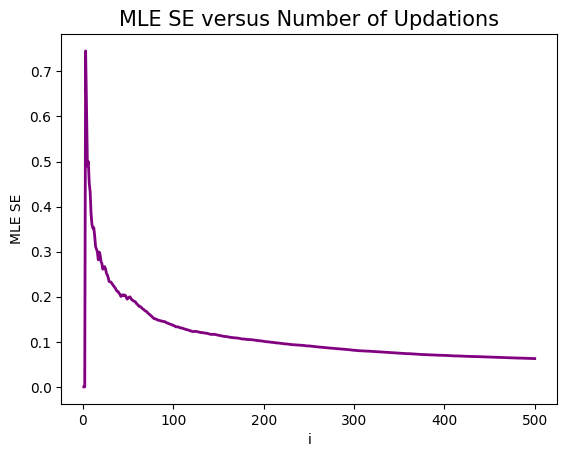

In [70]:
# plotting the mle standard deviation
plot_posterior_property("MLE SE", mle_err, color = "purple")

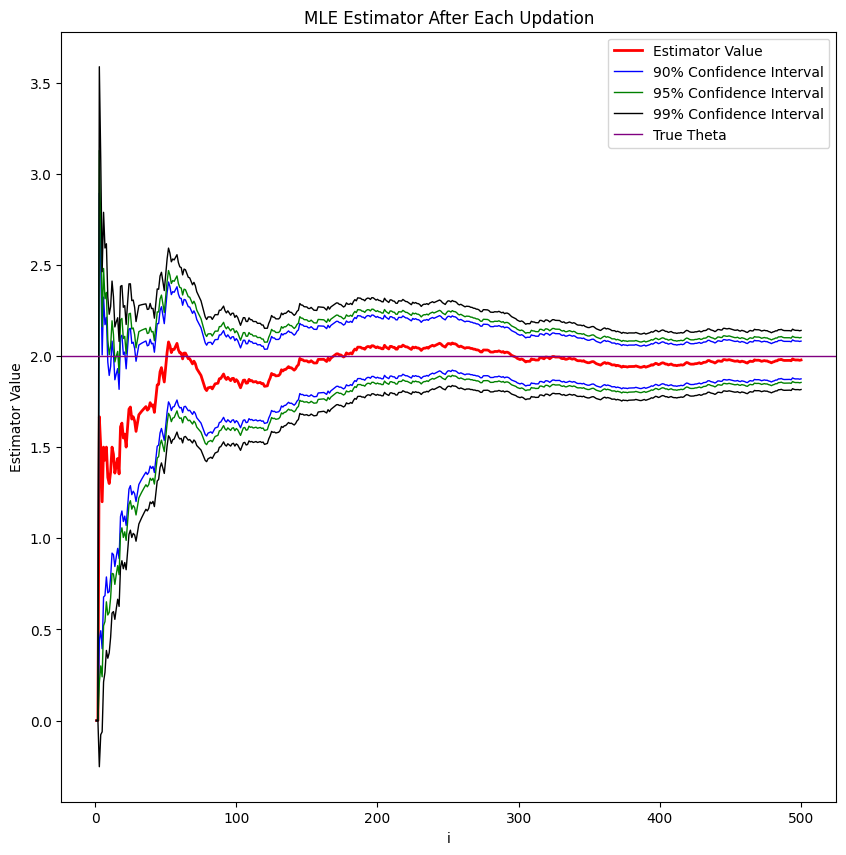

In [71]:
# plotting MLE values and CI's
plot_estimators("MLE Estimator", mle_value, mle_err)

# Part (i)

## Comparisons

<ipython-input-72-18c3236bad27>:4: RuntimeWarning: divide by zero encountered in divide
  posterior_std / mle_err,


Text(0.5, 1.0, 'Bayesian to MLE Std Dev Ratio vs Iterations')

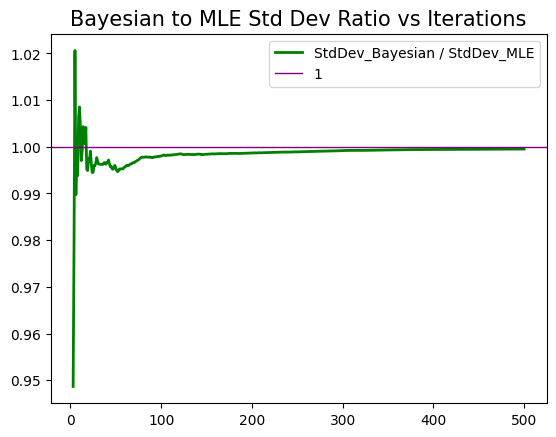

In [72]:
# plotting the relative values of the standard deviations
plt.plot(
    [i + 1 for i in range(SAMPLE_SIZE)],
    posterior_std / mle_err,
    lw = 2, color = "green",
    label = "StdDev_Bayesian / StdDev_MLE"
)
plt.axhline(
      y = 1,
      color = "purple", linestyle = "-", lw = 1,
      label= "1"
)
plt.legend()
plt.title("Bayesian to MLE Std Dev Ratio vs Iterations", fontsize = 15)

Text(0.5, 1.0, 'Absolute Errors with True Theta 2')

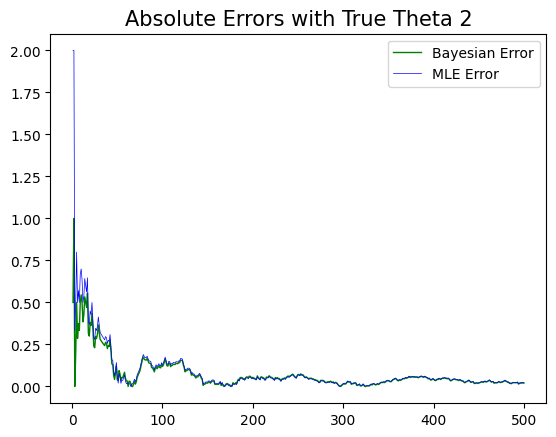

In [73]:
# plotting absolute errors from true value
plt.plot(
    [i + 1 for i in range(SAMPLE_SIZE)],
    abs(posterior_mean - 2),
    lw = 1, color = "green",
    label = "Bayesian Error"
)
plt.plot(
    [i + 1 for i in range(SAMPLE_SIZE)],
    abs(mle_value - 2),
    lw = 0.5, color = "blue",
    label = "MLE Error"
)
plt.legend()
plt.title("Absolute Errors with True Theta 2", fontsize = 15)

The sampling distribution of the MLE estimator is approximately Normal. For the Bayesian estimator, the posterior distribution is Gamma (due to our choice of using the conjugate prior Gamma for the Poisson model).

Bayesian estimator reaches closer to the true value of the parameter faster, as evidenced by green absolute errors (Bayesian) below the blue absolute errors (MLE) for sample sizes less than ~100 and by the sub-one standard error ratio.

**Effect of Sample Size:** As the sample size increases, the standard deviation/standard error for both Bayesian and MLE estimators become diminishingly small and their ratio converges to 1. The absolute errors from the true value become almost identical and "very small".